In [470]:
import pickle
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rl.fuzzing_action import FuzzingAction
from IPython.display import display, HTML

In [471]:
data_folder_names = [
    "2023-06-13T21:18:.106542_baseline",
    "2023-06-15T03:37:.169321",
    "2023-06-15T12:38:.323908",
    "2023-06-16T15:47:.430113",
]
# smart_folder_name = "2023-06-15T12:38:.323908"
# smart_interesting_folder = Path(f"../corpus/interesting/{smart_folder_name}")
data_labels = [
    "Baseline",
    "Smart (w/o pre-training)",
    "Smart (pre-trained)",
    "Smart (fine-tuned AST)",
]

data_folders = [Path(f"../data/{name}") for name in data_folder_names]

# smart_files = list(smart_folder.rglob("*.pkl"))
# baseline_files = list(baseline_folder.rglob("*.pkl"))

step_re = r"run_data_(\d+).pkl"

latest_steps = []

for folder in data_folders:
    files = list(folder.rglob("*.pkl"))
    run_data_file = max(files, key=lambda x: x.stat().st_ctime)
    step = int(re.match(step_re, run_data_file.name).group(1))
    latest_steps.append(step)

latest_step = min(latest_steps)
latest_steps[0] = min(latest_steps[0], max(latest_steps[1:]))
# latest_steps = [latest_step] * len(latest_steps)

In [472]:
run_data = []

for folder, step in zip(data_folders, latest_steps):
    with open(folder / f"run_data_{step}.pkl", "rb") as f:
        run_data.append(pickle.load(f))

In [473]:
summed_rewards = [[sum(episode) for episode in r["episode_rewards"]] for r in run_data]
episode_lengths = [[len(episode) for episode in r["episode_actions"]] for r in run_data]

data = {
    "Label": data_labels,
    "Running time": [data["running_time"] for data in run_data],
    "Total steps": [data["total_steps"] for data in run_data],
    "Total executions": [data["total_executions"] for data in run_data],
    "Final coverage": [f"{data['current_coverage']:.5%}" for data in run_data],
    "Number of episodes": [len(data["episode_rewards"]) for data in run_data],
    "Average episode reward": [f"{np.mean(rewards):.2f}" for rewards in summed_rewards],
    "Average episode length": [
        f"{np.mean(lengths):.2f}" for lengths in episode_lengths
    ],
}

display(pd.DataFrame(data))
# print("Labels: " + ", ".join(data_labels))
# print("Running times: " + ", ".join())
# print("Total steps: " + ", ".join([str(data["total_steps"]) for data in run_data]))
# print("Total executions: " + ", ".join([str(data["total_executions"]) for data in run_data]))
# print("Final coverage: " + ", ".join([f"{data['current_coverage']:.5%}" for data in run_data]))
# print("Number of episodes: " + ", ".join([str(len(data["episode_rewards"])) for data in run_data]))
# print(f"Average episode reward: "+ ", ".join([f"{np.mean(rewards):.2f}" for rewards in summed_rewards]))
# print("Average episode length: " + ", ".join([f"{np.mean(lengths):.2f}" for lengths in episode_lengths]))

,Label,Running time,Total steps,Total executions,Final coverage,Number of episodes,Average episode reward,Average episode length
0,Baseline,0 days 00:00:00.001655,132000,24173,21.05355%,14839,-5.61,8.89
1,Smart (w/o pre-training),1 days 10:10:20.121063,132000,95934,21.12446%,4767,5.51,27.69
2,Smart (pre-trained),0 days 17:51:11.776852,91000,63032,21.04798%,3406,3.45,26.71
3,Smart (fine-tuned AST),0 days 00:26:46.512957,41000,16093,20.93434%,1399,-8.58,29.30


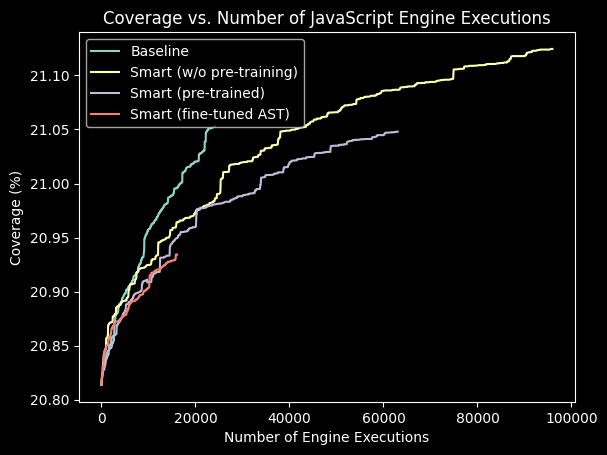

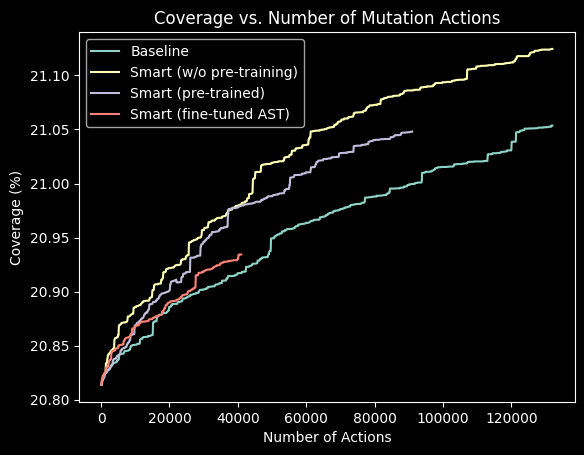

In [474]:
execs = []
actions = []
coverages = []

for data in run_data:
    run_execs = []
    run_actions = []
    run_coverage = []

    for (execution, num_actions), coverage in data["execution_coverage"].items():
        run_execs.append(execution)
        run_actions.append(num_actions)
        run_coverage.append(coverage * 100)

    execs.append(run_execs)
    actions.append(run_actions)
    coverages.append(run_coverage)

plt.figure()
plt.xlabel("Number of Engine Executions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of JavaScript Engine Executions")

for i, label in enumerate(data_labels):
    sns.lineplot(x=execs[i], y=coverages[i], label=label)

plt.legend(loc="upper left")
plt.show()

plt.figure()
plt.xlabel("Number of Actions")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs. Number of Mutation Actions")

for i, label in enumerate(data_labels):
    sns.lineplot(x=actions[i], y=coverages[i], label=label)

plt.legend(loc="upper left")
plt.show()

Text(0.5, 1.0, 'Episode Rewards')

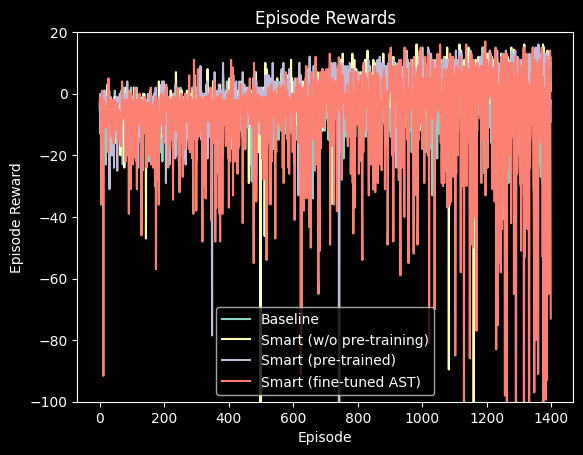

In [475]:
episodes = min([len(data["episode_rewards"]) for data in run_data])

plt.figure()
for i, label in enumerate(data_labels):
    sns.lineplot(
        x=np.arange(len(summed_rewards[i][:episodes])),
        y=summed_rewards[i][:episodes],
        label=label,
    )
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.ylim(-100, 20)

plt.title("Episode Rewards")

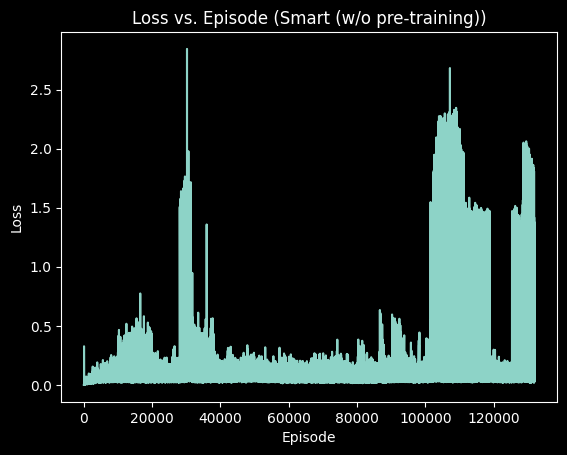

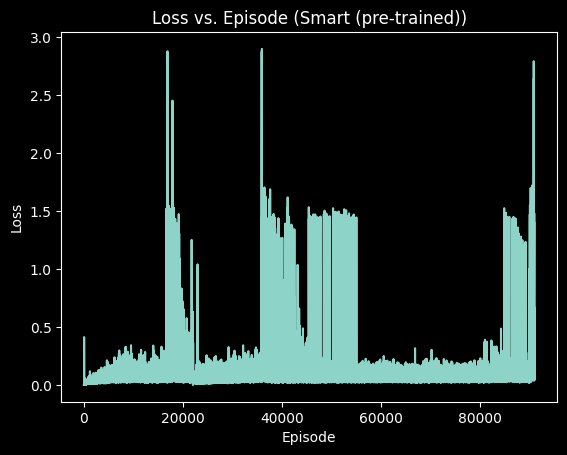

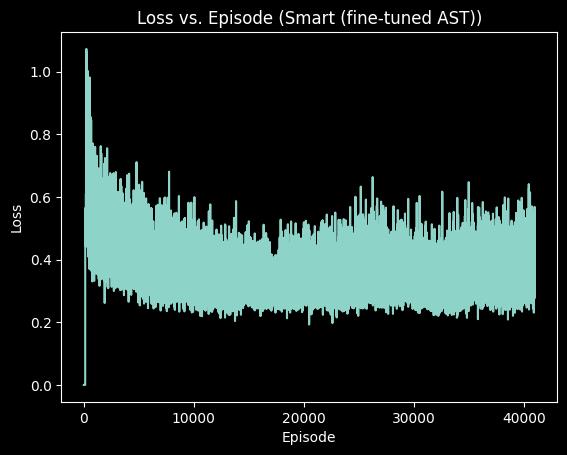

In [476]:
for i, label in enumerate(data_labels):
    if "losses" in run_data[i]:
        plt.figure()
        ax = sns.lineplot(
            x=np.arange(len(run_data[i]["losses"])),
            y=run_data[i]["losses"],
        )
        ax.set(xlabel="Episode", ylabel="Loss", title=f"Loss vs. Episode ({label})")

In [477]:
# for action in FuzzingAction:
#     smart_episode_actions_by_type = [
#         x[1] for x in smart_episode_actions if x[0] == action
#     ]
#     baseline_episode_actions_by_type = [
#         x[1] for x in baseline_episode_actions if x[0] == action
#     ]

#     smart_action_node_type_counts = Counter(smart_episode_actions_by_type)
#     baseline_action_node_type_counts = Counter(baseline_episode_actions_by_type)

#     smart_action_node_type_counts = pd.DataFrame(
#         smart_action_node_type_counts.items(), columns=["node_type", "count"]
#     )
#     baseline_action_node_type_counts = pd.DataFrame(
#         baseline_action_node_type_counts.items(), columns=["node_type", "count"]
#     )

#     # Plot the distribution of actions by node type using seaborn
#     plt.figure(figsize=(15, 5))
#     ax = sns.barplot(x="node_type", y="count", data=smart_action_node_type_counts)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#     ax.set(xlabel="Node Type", ylabel="Count")
#     plt.title(f"Smart Fuzzing Action Distribution for {action}")

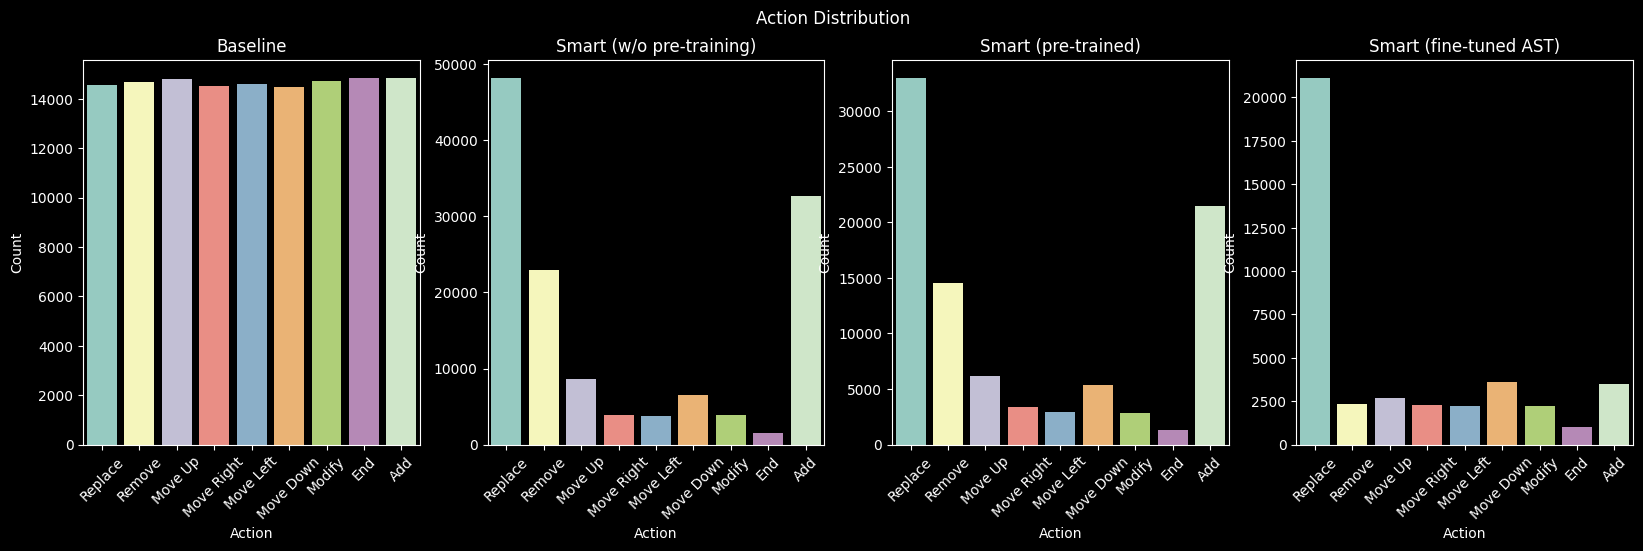

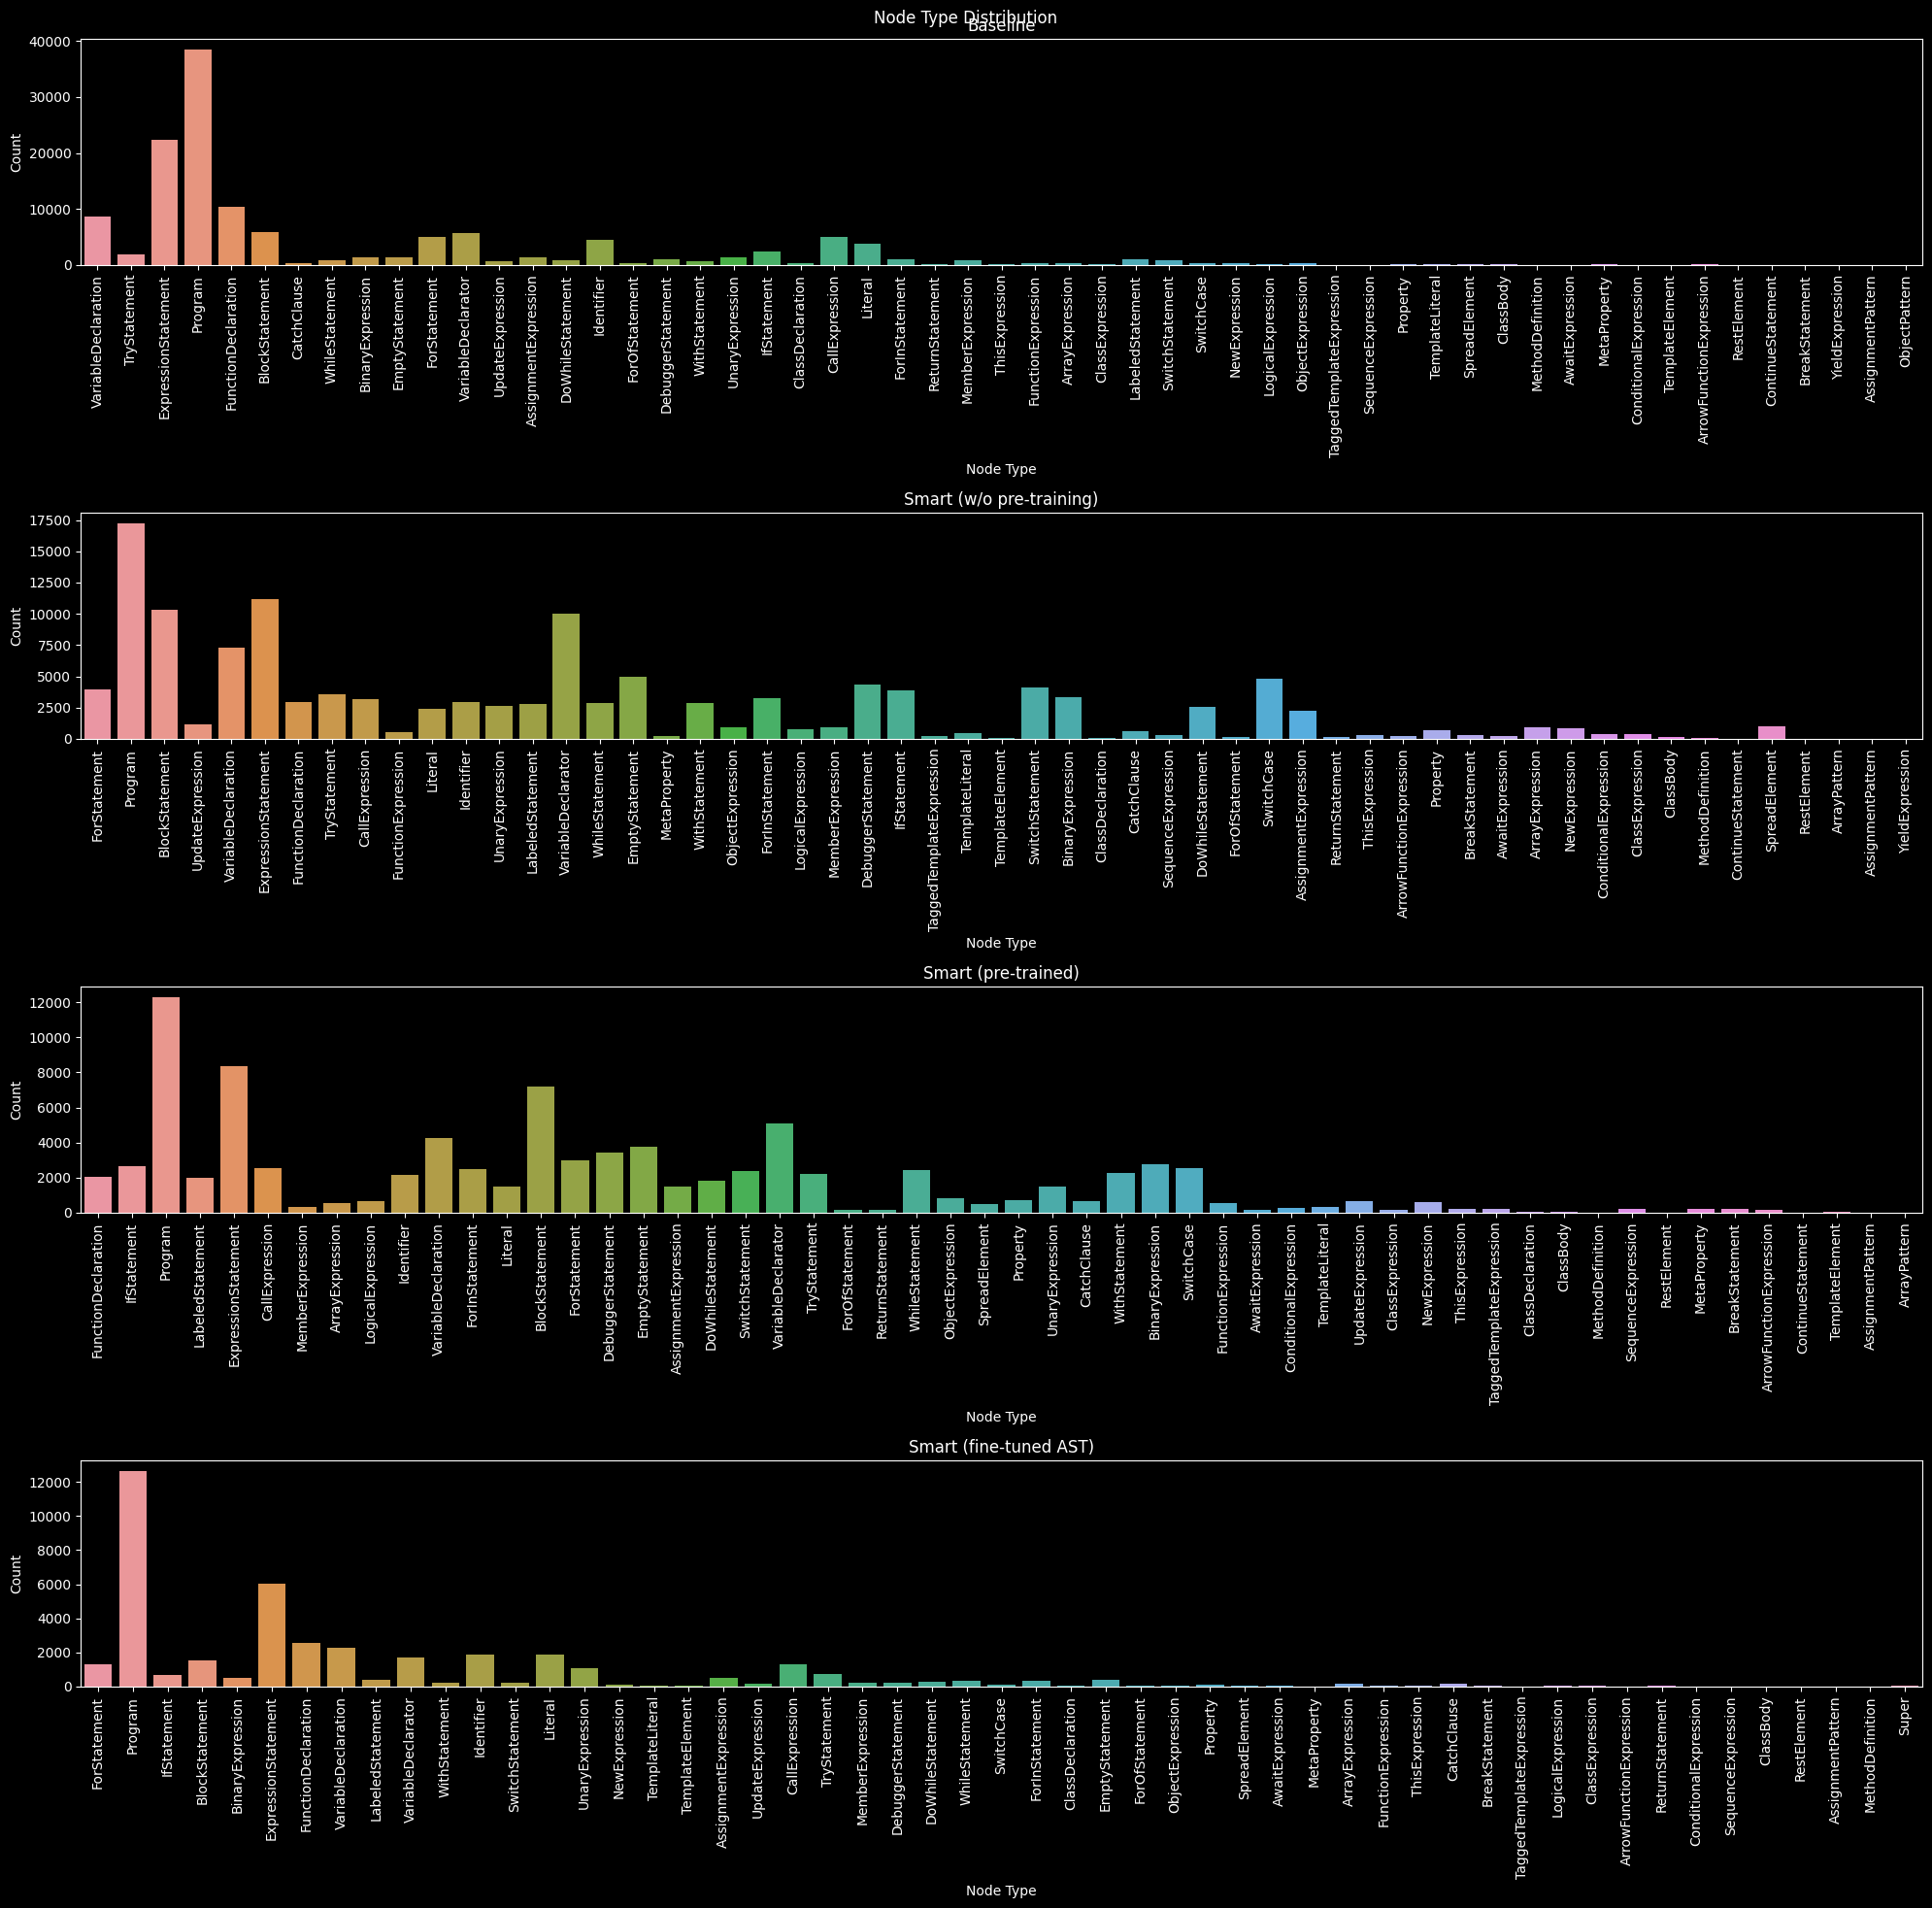

In [478]:
action_fig, action_axs = plt.subplots(ncols=len(data_labels), figsize=(20, 5))
action_fig.suptitle("Action Distribution")

node_type_fig, node_tyes_axs = plt.subplots(nrows=len(data_labels), figsize=(20, 20))
node_type_fig.suptitle("Node Type Distribution")

for i, label in enumerate(data_labels):
    episode_actions = [
        item for sublist in run_data[i]["episode_actions"] for item in sublist
    ]
    actions, node_types = zip(*episode_actions)
    action_counts = Counter(actions)
    node_type_counts = Counter(node_types)

    action_counts = pd.DataFrame.from_dict(action_counts, orient="index")
    action_counts["name"] = [str(FuzzingAction(i)) for i in action_counts.index]
    action_counts = action_counts.sort_values(by="name", ascending=False)

    node_type_counts = pd.DataFrame.from_dict(node_type_counts, orient="index")
    node_type_counts["name"] = node_type_counts.index

    sns.barplot(x="name", y=0, data=action_counts, ax=action_axs[i])

    action_axs[i].set(xlabel="Action", ylabel="Count", title=f"{label}")
    action_axs[i].set_xticklabels(action_axs[i].get_xticklabels(), rotation=45)

    # plt.legend([], [], frameon=False)

    sns.barplot(x="name", y=0, data=node_type_counts, ax=node_tyes_axs[i])

    node_tyes_axs[i].set(xlabel="Node Type", ylabel="Count", title=f"{label}")
    node_tyes_axs[i].set_xticklabels(node_tyes_axs[i].get_xticklabels(), rotation=90)
    # plt.legend([], [], frameon=False)

plt.tight_layout()
# plt.figure()
# ax = sns.barplot(x="name", y=0, data=smart_action_counts)
# ax.set(xlabel="Action", ylabel="Count", title="Smart Agent Action Counts")
# plt.legend([], [], frameon=False)

# plt.figure()
# ax = sns.barplot(x="name", y=0, data=baseline_action_counts)
# ax.set(xlabel="Action", ylabel="Count", title="Baseline Agent Action Counts")
# plt.legend([], [], frameon=False)

# plt.figure(figsize=(20, 5))
# ax = sns.barplot(x="name", y=0, data=smart_node_type_counts)
# ax.set(xlabel="Node Type", ylabel="Count", title="Smart Agent Node Type Visit Counts")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.legend([], [], frameon=False)


# plt.figure(figsize=(20, 5))
# ax = sns.barplot(x="name", y=0, data=baseline_node_type_counts)
# ax.set(
#     xlabel="Node Type", ylabel="Count", title="Baseline Agent Node Type Visit Counts"
# )
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.legend([], [], frameon=False)

In [479]:
# with open("../data/js-rl/corpus.pkl", "rb") as f:
#     data = pickle.load(f)

# corpus = data["corpus"]
# subtrees = data["subtrees"]
# total_coverage = data["total_coverage"]

# file_to_node = {
#     state.program.origin_file: state for state in corpus
# }

# program_state_files = smart_interesting_folder.rglob("*.ps")
# program_states = {
#     file: pickle.load(open(file, "rb"))
#     for file in program_state_files
# }

# import difflib

# for file, state in program_states.items():
#     new_program = state.generate_program_code()
#     if new_program is None:
#         print(f"File {file} failed to generate program code")
#         continue

#     if state.program.origin_file not in file_to_node:
#         print(f"File {state.program.origin_file} not found")

#     old_program = file_to_node[state.program.origin_file].generate_program_code()

#     old_program = '\n'.join(['--- Original File ---', old_program])
#     new_program = '\n'.join(['+++ Modified File +++', new_program])

#     diff_generator = difflib.unified_diff(
#         old_program.splitlines(keepends=True),
#         new_program.splitlines(keepends=True),
#     )

#     # Write the diff to the output file
#     with open(file.with_suffix(".diff"), 'w') as f:
#         f.writelines(diff_generator)